Error minimizing using different values of angle per increment for each encoder

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
# from support.omniwheel_calculation_pd import *
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from support.generate_ar_data import *

from numba import njit
import polars as pl
from support.imu_calculations import *
import msgpack as mp

from scipy.interpolate import interp1d

In [2]:
_parent_folder = "omni_cam_9d0f_may_8_2023"
_folder_name = "sk36_30_random_01"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.dirname(_base_pth)
_base_pth = os.path.join(_base_pth,"recording_programs", "test_data", _parent_folder)

_calibration_folder = "calibration_00"

_pth = os.path.join(_base_pth, _folder_name)
_calib_pth = os.path.join(_base_pth, _calibration_folder)

_base_pth

# C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_9dof_april_20_2023\sk32_00_test_slow_00\imu01.csv

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\omni_cam_9d0f_may_8_2023'

In [3]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  _sk_df["e_t"]
_sk_df["e_rr"] = -_sk_df["e_rr"]
_sk_df["e_rl"] = -_sk_df["e_rl"]

In [4]:
y = (19.7/2)/100 # meters
# y = (19.7)/100 # meters
x = 18.5/200 # meters
radius = 5.5/200 # meters

df = _sk_df
df = set_zero(df)
df, ang_col = get_angular_velocity(df, ang_per_increment=0.15, del_t=0.01)

df, vel_col = get_directional_velocity(df, ang_col, radius=radius, x = x, y = y)
df, col_names = get_position(df)
df, _ang_name = get_orientation(df)

sk_df = df[["time", "e_t", "e_rr", "e_rl"]]

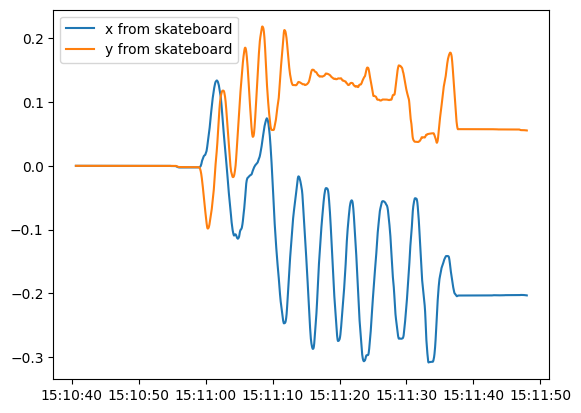

In [5]:
plt.plot(df["time"], df["x"], label="x from skateboard")
plt.plot(df["time"], df["y"], label="y from skateboard")
plt.legend()
# plt.plot(df["time"], df["theta"], label="e_rl")

In [6]:

#read the calibration file
_webcam_calib_folder = _calib_pth
_webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)
_webcam_calib_pth = os.path.join(_base_pth, _webcam_calib_folder, "webcam_calibration.msgpack")


with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]
_webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")
_webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")


with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)
print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)


camera matrix [[880.19523452   0.         358.2789884 ]
 [  0.         881.87061144 242.70902376]
 [  0.           0.           1.        ]]
distortion [[ 1.24325941e-01 -1.20330000e-01 -2.99461015e-03 -1.15851300e-03
  -3.99283638e+00]]


In [7]:
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)
_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)

In [8]:
_w_df = _w_df.rename(columns={"yaw": "rx", "pitch": "ry", "roll": "rz"})
ar_angle = pl.from_pandas(_w_df)

r_mat = []
for i in range(len(ar_angle)):
    _tmp = ar_angle[["rx", "ry", "rz"]][i].to_numpy()
    r_mat.append(cv2.Rodrigues(_tmp)[0])

_del_ar_r = []
for i in range(len(r_mat)):
    _del_ar_r.append(r_mat[0].T@r_mat[i])

#getting angle from rotmat

_ar_theta_x = []
_ar_theta_y = []
_ar_theta_z = []

for i in _del_ar_r:
    _ar_theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _ar_theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _ar_theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_ar_theta_x = np.array(_ar_theta_x)
_ar_theta_y = np.array(_ar_theta_y)
_ar_theta_z = np.array(_ar_theta_z)

In [9]:
# plt.plot(_w_df["time"], _ar_ang_df["theta_x"].rolling(19).median(), label="theta x")
# # plt.plot(_w_df["time"], _ar_ang_df["theta_y"].rolling(19).median(), label="theta y")
# # plt.plot(_w_df["time"], _ar_ang_df["theta_z"].rolling(19).median(), label="theta z")
# plt.legend()

In [10]:
# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
# type in marker details sk35
_xm = get_rb_marker_name(6)
_ym = get_rb_marker_name(4)
_om = get_rb_marker_name(8)

# Mocap markers in aruco plate
_ar_tr = get_rb_marker_name(7)
_ar_tl = get_rb_marker_name(2)
_ar_br = get_rb_marker_name(3)
_ar_bl = get_rb_marker_name(1)

In [11]:
_mocap_ar = pd.DataFrame()
_m_df = _mocap_df
_mocap_ar["time"] = _m_df["time"]
_mocap_ar["x"] = _m_df[_ar_tr["x"]] + _m_df[_ar_tl["x"]] + _m_df[_ar_br["x"]] + _m_df[_ar_bl["x"]]
_mocap_ar["y"] = _m_df[_ar_tr["y"]] + _m_df[_ar_tl["y"]] + _m_df[_ar_br["y"]] + _m_df[_ar_bl["y"]]
_mocap_ar["z"] = _m_df[_ar_tr["z"]] + _m_df[_ar_tl["z"]] + _m_df[_ar_br["z"]] + _m_df[_ar_bl["z"]]

_mocap_ar["x"] = _mocap_ar["x"] / 4
_mocap_ar["y"] = _mocap_ar["y"] / 4
_mocap_ar["z"] = _mocap_ar["z"] / 4

In [12]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df[_ym["x"]].iloc[0], _mocap_df[_ym["y"]].iloc[0], _mocap_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [13]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]


In [14]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 5860/5860 [00:05<00:00, 1145.70it/s]


In [15]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 5860/5860 [00:00<00:00, 182941.98it/s]


mocap reverse

In [16]:
"""
Transforming mocap data to robot frame of reference
Computing u1, u2, u3 from mocap data
"""

_mocap_rev = _mc_df[["time",'x', 'y']].copy()
_mocap_rev["theta"] = _theta_z
_mocap_rev["vx"] = -_mocap_rev["x"].diff() / 0.01
_mocap_rev["vy"] = _mocap_rev["y"].diff() / 0.01
_mocap_rev["wx"] = -_mocap_rev["theta"].diff() / 0.01
_mocap_rev = _mocap_rev.fillna(0)

mat = np.array([[-y, 1, 0], [-x, 0, -1], [x, 0, -1]])

_uvec = {"u1":[], "u2":[], "u3":[]}
_mocap_rev = pl.from_pandas(_mocap_rev)
for i in tqdm(range(len(_mocap_rev))):
    _uvec["u1"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][0])
    _uvec["u2"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][1])
    _uvec["u3"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][2])


_mocap_rev = _mocap_rev.to_pandas()
_mocap_rev["u1"] = np.deg2rad(_uvec["u1"])
_mocap_rev["u2"] = np.deg2rad(_uvec["u2"])
_mocap_rev["u3"] = np.deg2rad(_uvec["u3"])


100%|██████████| 5860/5860 [00:02<00:00, 2445.77it/s]


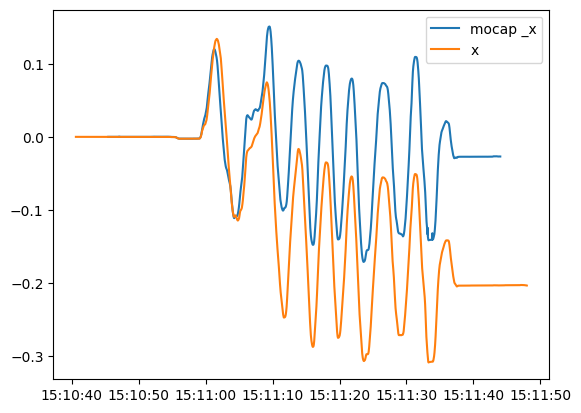

In [17]:
plt.plot(_m_df["time"], _mc_df["x"], label="mocap _x")
plt.plot(df["time"], df["x"], label="x")
plt.legend()

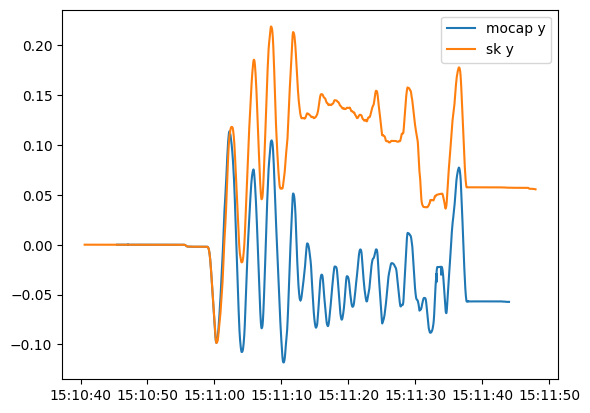

In [18]:
plt.plot(_m_df["time"], _mc_df["y"], label="mocap y")
plt.plot(df["time"], df["y"], label="sk y")
plt.legend()
# df.columns

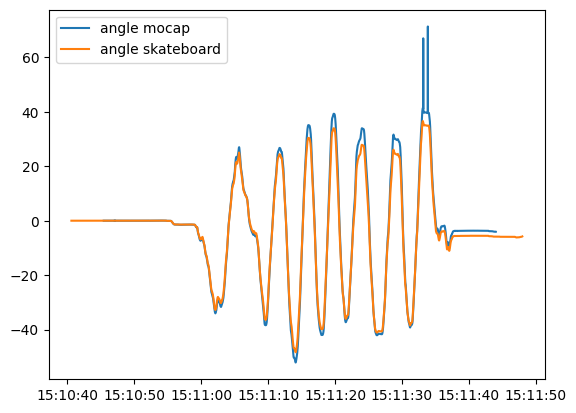

In [19]:
plt.plot(_m_df["time"], _theta_z, label="angle mocap")
plt.plot(df["time"], -np.rad2deg(df["theta"]), label="angle skateboard")
# plt.plot(_w_df["time"], np.rad2deg(_ar_ang_df["theta_x"].rolling(19).median()), label="Aruco theta x")

plt.legend()

In [20]:
def get_dir_vel2(df, ang_col, radius=radius, x = x, y = y,  mocap_ang= None):

    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False 

    column_name = ang_col
    print(column_name)
    my_dict = {"_vx":[],"_vy":[],"_w":[]}

    for i in range(len(df)):

        mat = np.array([[1, 0, 0],
                        [0, np.cos(mocap_ang[i]), -np.sin(mocap_ang[i])],
                        [0, np.sin(mocap_ang[i]), np.cos(mocap_ang[i])]]) # matrix for calculating the directional velocity

        pmat = np.linalg.pinv(mat)
        val = df[column_name][i].to_numpy().reshape(3,1)
        res = np.dot(pmat, val) * radius

        my_dict["_w"].append(res[0][0])
        my_dict["_vx"].append(res[1][0])
        my_dict["_vy"].append(res[2][0])


    # add the calculated values to the dataframe
    df = df.with_columns([pl.Series(name = "vx2", values = my_dict["_vx"]),
                        pl.Series(name = "vy2", values = my_dict["_vy"]),
                            pl.Series(name = "w2", values = my_dict["_w"])])
    
    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()

    return df, df.columns

def get_position2(df, dt = 0.007):
    """
    Calculate the position of the robot

    df should have "vx", "vy", "w" columns to calculate the position
    """
    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False
    
    df = df.with_columns([(pl.col("vx2").cumsum() * dt).alias("x2"),
                            (pl.col("vy2").cumsum() * dt).alias("y2")])
    
    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()
    
    return df, ["x2", "y2"]

def get_orientation2(df, dt = 0.007, column_name = "w"):

    """
    Calculate the angle of the chasis, with respect to initial frame

    df should have "w" column to calculate the angle
    """
    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False

    if not column_name:
        column_name = "w2"

    # calculate the cumulative sum of the values multiplied by dt

    df = df.with_columns([(pl.col("w2").cumsum() * dt).alias("theta2")])


    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()

    return df, ["theta2"]

In [61]:
newdf, _ = get_dir_vel2(df, ang_col, mocap_ang= -np.deg2rad(_imu_df["ang_z"]))
newdf, _ = get_position2(newdf)
newdf, _ = get_orientation2(newdf)

['e_t_av', 'e_rr_av', 'e_rl_av']


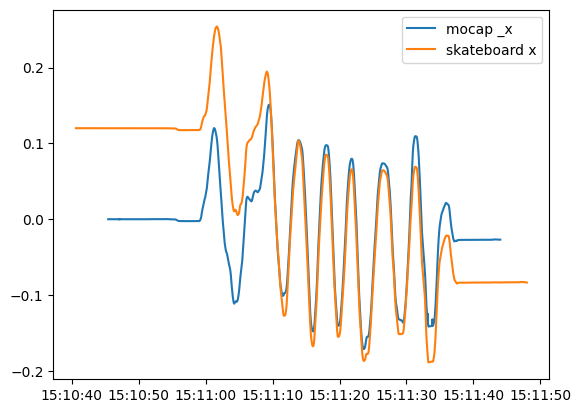

In [73]:
plt.plot(_m_df["time"], _mc_df["x"], label="mocap _x")
plt.plot(df["time"], df["x"] + 0.12, label="skateboard x")
# plt.plot(_sk_transposed["time"], _sk_transposed["x2"]/300, label="x")
# plt.plot(newdf["time"], newdf["x2"], label="x2")
plt.legend()

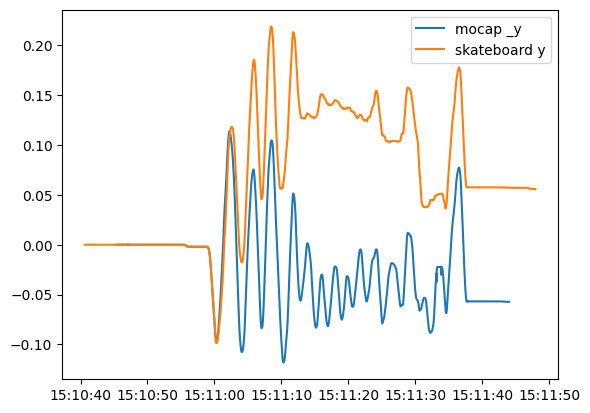

In [67]:
plt.plot(_m_df["time"], _mc_df["y"], label="mocap _y")
plt.plot(df["time"], df["y"], label="skateboard y")
# plt.plot(newdf["time"], -newdf["x2"], label="y2")

# plt.plot(_sk_transposed["time"], _sk_transposed["y2"]/300, label="y")
plt.legend()

In [24]:
def transform_coordinates_1(df, rotmat, org, correction=False, translation_correction=None):

    df1 = df.copy( deep=True)

    if translation_correction is None:
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        _val = rotmat.T @ _temp
        if correction:
            _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [25]:
w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org, correction=True)
_initial_ref = _mocap_ar[['x', 'y', 'z']].loc[0]
_initial_ref = np.array(_initial_ref).reshape(3,1)
_transform_ref = rotMat.T @ (_initial_ref - org)

ar_df = transform_coordinates_1(w_df, rotMat, org=org, correction=True)

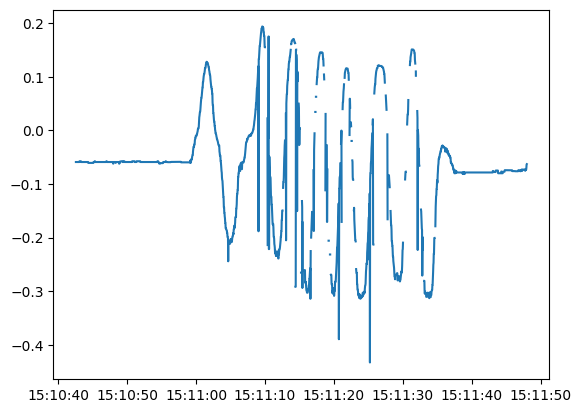

In [26]:
plt.plot(w_df["time"], ar_df["x"], label="mocap _x")

Mocap reverse

In [27]:
"""
Transforming mocap data to robot frame of reference
Computing u1, u2, u3 from mocap data
"""

_mocap_rev = _mc_df[["time",'x', 'y']].copy()
_mocap_rev["theta"] = _theta_z
_mocap_rev["vx"] = -_mocap_rev["x"].diff() / 0.01
_mocap_rev["vy"] = _mocap_rev["y"].diff() / 0.01
_mocap_rev["wx"] = -_mocap_rev["theta"].diff() / 0.01
_mocap_rev = _mocap_rev.fillna(0)

mat = np.array([[-y, 1, 0], [-x, 0, -1], [x, 0, -1]])

_uvec = {"u1":[], "u2":[], "u3":[]}
_mocap_rev = pl.from_pandas(_mocap_rev)
for i in tqdm(range(len(_mocap_rev))):
    _uvec["u1"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][0])
    _uvec["u2"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][1])
    _uvec["u3"].append(((1/radius)*(mat @ _mocap_rev[["wx", "vx", "vy"]][i].to_numpy().reshape(3,1))).T[0][2])


_mocap_rev = _mocap_rev.to_pandas()
_mocap_rev["u1"] = np.rad2deg(_uvec["u1"])
_mocap_rev["u2"] = np.rad2deg(_uvec["u2"])
_mocap_rev["u3"] = np.rad2deg(_uvec["u3"])


100%|██████████| 5860/5860 [00:02<00:00, 2544.85it/s]


In [28]:
_imu_df = _sk_df[["time", "mils", "ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz"]].copy()
_imu_df = pl.from_pandas(_imu_df)
dt = _imu_df["mils"].diff().mean()/1000
dt = 0.01
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter

_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])


_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

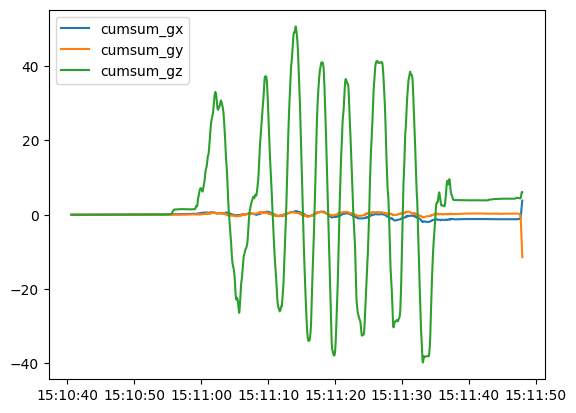

In [29]:
plt.plot(_imu_df["time"], _imu_df["ang_x"], label="cumsum_gx")
plt.plot(_imu_df["time"], _imu_df["ang_y"], label="cumsum_gy")
plt.plot(_imu_df["time"], _imu_df["ang_z"], label="cumsum_gz")
plt.legend()

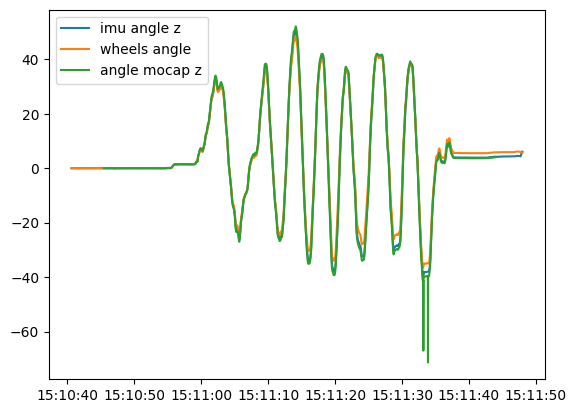

In [30]:
plt.plot(_imu_df["time"], _imu_df["ang_z"], label="imu angle z")
plt.plot(_imu_df["time"], np.rad2deg(df["theta"]), label="wheels angle")
plt.plot(_m_df["time"], -_theta_z, label="angle mocap z")
plt.legend()

In [131]:
if type(ar_df) == pd.DataFrame:
    ar_df = pl.from_pandas(ar_df)
filter_size = 5
filter_order = 1
ar_df = ar_df.with_columns([
                        pl.col("x").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode().alias("fx"),
                        pl.col("y").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode().alias("fy"),
                        pl.col("z").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode().alias("fz"),
                    ])

ar_df = ar_df.to_pandas()

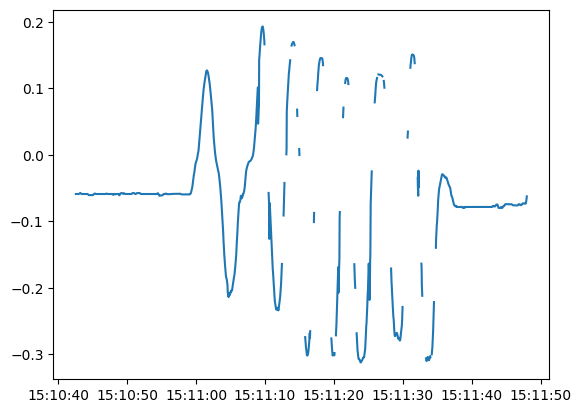

In [111]:
plt.plot(ar_df["time"], ar_df["fx"], label="fx")

In [127]:
from support.pd_support import *

In [139]:
newdf = interpolate_target_df(df, ar_df, col_names=["x", "y"])

In [140]:
newdf

,x,y,time
0,0.000000,0.000000,2023-05-08 15:10:42.566939
1,0.000000,0.000000,2023-05-08 15:10:42.599412
2,0.000000,0.000000,2023-05-08 15:10:42.627001
3,0.000000,0.000000,2023-05-08 15:10:42.657500
4,0.000000,0.000000,2023-05-08 15:10:42.704661
...,...,...,...
1958,-0.203235,0.055760,2023-05-08 15:11:47.873122
1959,-0.203274,0.055723,2023-05-08 15:11:47.899940
1960,-0.203311,0.055688,2023-05-08 15:11:47.931439
1961,-0.203425,0.055581,2023-05-08 15:11:47.962441
